# LLMs for Mental Health Early Detection

## 1. Loading and Cleaning the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./reddit_scraping/reddit_scraped_posts.csv')
df.head()

,subreddit,title,author,post_url,created_utc,body,score,num_comments,top_comments
0,depression,I wish someone would just...,ShadowForme76,https://www.reddit.com/r/depression/comments/1...,2024-06-15 02:24:16,Just fucking kill me. Shoot me. I wish I could...,1692,242,Life is overall shitty and borderline unbearab...
1,depression,A friend of mine once described depression as ...,2gkfcxs,https://www.reddit.com/r/depression/comments/1...,2024-06-15 04:42:57,And felt like that is the most apt description...,1672,100,Whenever I was younger and when I was at my lo...
2,depression,Therapist explained to me that normally people...,Single_Pizza4867,https://www.reddit.com/r/depression/comments/1...,2024-09-04 22:24:46,This has destroyed me. I’ve always thought may...,1437,156,Sometimes I stew for HOURS on this. How are pe...
3,depression,"Everyone says if you're depressed, don't be af...",throwawayls0622,https://www.reddit.com/r/depression/comments/1...,2024-10-22 16:41:27,"Well, we try to. And guess what? No one cares....",1392,282,"Thing is, even if someone did care, I do not w..."
4,depression,Quiet quitting life,Flashy_Shop_9963,https://www.reddit.com/r/depression/comments/1...,2024-10-17 16:26:16,I am quiet quitting life and nobody realizes t...,1235,102,Man holy shit I’ve never related to something ...


In [3]:
print(df.isnull().sum())

df = df.dropna(subset=['body']).reset_index(drop=True)

subreddit        0
title            0
author           0
post_url         0
created_utc      0
body            35
score            0
num_comments     0
top_comments     0
dtype: int64


In [4]:
print(df.isnull().sum())

subreddit       0
title           0
author          0
post_url        0
created_utc     0
body            0
score           0
num_comments    0
top_comments    0
dtype: int64


We remove all empty posts.

In [5]:
# Convert 'created_utc' to datetime if not already
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Check date range in a DataFrame
df['created_utc'].min()  # Earliest date
df['created_utc'].max()  # Latest date

# Get full range info
print(f"Date range: {df['created_utc'].min()} to {df['created_utc'].max()}")
print(f"Total days: {(df['created_utc'].max() - df['created_utc'].min()).days}")

Date range: 2024-05-01 01:27:26 to 2025-01-02 19:23:56
Total days: 246


In [6]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777 entries, 0 to 3776
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   subreddit     3777 non-null   object        
 1   title         3777 non-null   object        
 2   author        3777 non-null   object        
 3   post_url      3777 non-null   object        
 4   created_utc   3777 non-null   datetime64[ns]
 5   body          3777 non-null   object        
 6   score         3777 non-null   int64         
 7   num_comments  3777 non-null   int64         
 8   top_comments  3777 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 265.7+ KB


,score,num_comments
count,3777.000000,3777.000000
mean,111.117818,57.521843
std,141.614107,75.875924
min,12.000000,1.000000
25%,39.000000,18.000000
50%,68.000000,36.000000
75%,125.000000,64.000000
max,2509.000000,990.000000


From the info we can know the types of raw data and also the score and the number of comments distribution. The score field refers to the total net votes a post has received. The score is a rough measure of popularity or agreement. It is not always an indicator of quality, especially on controversial or emotional posts.

In [7]:
df['subreddit'].value_counts()

depression      959
PTSD            954
mentalhealth    943
anxiety         921
Name: subreddit, dtype: int64

This is the distribution of each subreddit, the number of posts in each subreddit is close.

<Axes: >

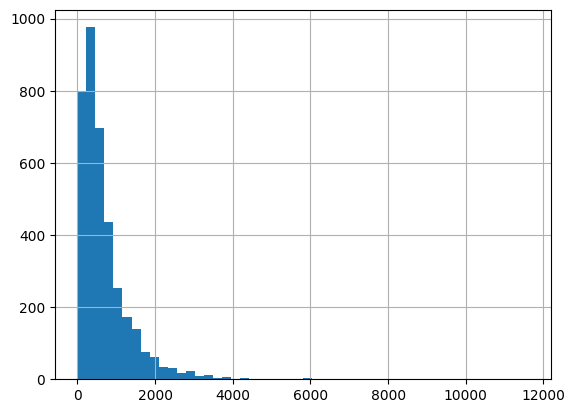

In [8]:
df['text_length'] = df['body'].astype(str).apply(len)
df['text_length'].hist(bins=50)

This graph shows the distribution of text length in each posts.

## 2. NLP preprocessing & feature extraction
In this part we will experiment the NLP preprocessing and feature extraction by LIWC. We will apply WorldPiece tokenization to match our LLM vocabularies. Due to LIWC is not open sources so we choose to use Empath as a alternative method.

In [9]:
#! pip install nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

### 2.1 Text cleaning

In [10]:
def clean_text(text):
    if not isinstance(text, str):  # Handles NaN, None, etc.
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove non-alphabetic characters (preserve space)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(cleaned)

In [11]:
df['clean_body'] = df['body'].apply(clean_text)
df[['body', 'clean_body']].sample(5)

,body,clean_body
1048,this is a cry for help. i wake up anxious near...,cry help wake anxious nearly every single day ...
3540,"I used to have some problems. It got better, b...",used problem got better getting worse combinat...
3448,Especially anxiety?,especially anxiety
3329,To Those Who Grew Up Feeling Like a Burden: Yo...,grew feeling like burden never meant carry wei...
1163,What medication works best for GAD?,medication work best gad


In [12]:
df['clean_comments'] = df['top_comments'].apply(clean_text)
df[['top_comments', 'clean_comments']].sample(5)

,top_comments,clean_comments
1331,Don’t fight it. Allow it to be. Thank your bod...,dont fight allow thank body trying protect may...
2483,*r/ptsd has generated this automated response ...,rptsd generated automated response appended ev...
2039,*r/ptsd has generated this automated response ...,rptsd generated automated response appended ev...
3607,**Hello u/!** \n\nThank you for tagging this p...,hello u thank tagging post content warning hel...
3159,someone loved the parts of me I thought were u...,someone loved part thought unlovable even pers...


By the steps of above, we did remove emojis, links, and special characters, tokenization, lowercasing, stopword removal, and lemmatization. These steps reduce noise and standardize the data, ensuring that both LLMs and traditional feature extractors(LIWC) can process the input effectively.

#### 2.1.1 Blank text after cleaning

In [13]:
df['clean_body'] = df['clean_body'].fillna("").astype(str)
df = df[df['clean_body'].str.strip() != ""]

In [14]:
df['clean_body'].apply(lambda x: len(x.strip()) == 0).sum()

0

### 2.2 Extract LIWC-style features (via Empath)

In [15]:
# ! pip install empath
from empath import Empath
lexicon = Empath()

# Apply Empath to each cleaned post
df['liwc_empath'] = df['clean_body'].apply(lambda x: lexicon.analyze(x, normalize=True))

print(df['liwc_empath'].head())

0    {'help': 0.0, 'office': 0.005747126436781609, ...
1    {'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...
2    {'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...
3    {'help': 0.029411764705882353, 'office': 0.0, ...
4    {'help': 0.02040816326530612, 'office': 0.0, '...
Name: liwc_empath, dtype: object


In [16]:
df['liwc_empath'][1]

{'help': 0.0,
 'office': 0.0,
 'dance': 0.0,
 'money': 0.0,
 'wedding': 0.1,
 'domestic_work': 0.0,
 'sleep': 0.0,
 'medical_emergency': 0.0,
 'cold': 0.1,
 'hate': 0.0,
 'cheerfulness': 0.0,
 'aggression': 0.0,
 'occupation': 0.0,
 'envy': 0.0,
 'anticipation': 0.0,
 'family': 0.0,
 'vacation': 0.0,
 'crime': 0.0,
 'attractive': 0.0,
 'masculine': 0.0,
 'prison': 0.0,
 'health': 0.0,
 'pride': 0.0,
 'dispute': 0.0,
 'nervousness': 0.1,
 'government': 0.0,
 'weakness': 0.0,
 'horror': 0.0,
 'swearing_terms': 0.0,
 'leisure': 0.0,
 'suffering': 0.0,
 'royalty': 0.0,
 'wealthy': 0.0,
 'tourism': 0.0,
 'furniture': 0.0,
 'school': 0.0,
 'magic': 0.0,
 'beach': 0.0,
 'journalism': 0.0,
 'morning': 0.0,
 'banking': 0.0,
 'social_media': 0.0,
 'exercise': 0.0,
 'night': 0.0,
 'kill': 0.0,
 'blue_collar_job': 0.0,
 'art': 0.0,
 'ridicule': 0.0,
 'play': 0.0,
 'computer': 0.0,
 'college': 0.0,
 'optimism': 0.0,
 'stealing': 0.0,
 'real_estate': 0.0,
 'home': 0.0,
 'divine': 0.0,
 'sexual': 0.0

In [17]:
df['liwc_empath'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

0

In [18]:
df = df[df['liwc_empath'].apply(lambda x: isinstance(x, dict) and len(x) > 0)]

We can see that Empath features simulates LIWC output and provides psychological signals extracted from the post. It numerically summarizes the content in terms of emotion, behavior, and social context.

### 2.3 Circumplex Model Mapping
In this part we extract each emotional category to set it as valence and arousal score.

In [19]:
def map_to_circumplex(empath_dict):
    # Define emotional categories
    pos_valence = ['joy', 'contentment', 'cheerfulness', 'love', 'optimism', 'trust', 'positive_emotion', 'affection', 'giving']
    neg_valence = ['sadness', 'pain', 'fear', 'shame', 'anger', 'hate', 'torment', 'violence', 'suffering', 'negative_emotion']

    high_arousal = ['violence', 'fear', 'anger', 'nervousness', 'aggression', 'shame', 'surprise', 'exasperation', 'disgust']
    low_arousal = ['sleep', 'leisure', 'contentment', 'calm', 'relaxation', 'boredom', 'peace']

    # Calculate weighted scores
    valence = sum([empath_dict.get(w, 0.0) for w in pos_valence]) - sum([empath_dict.get(w, 0.0) for w in neg_valence])
    arousal = sum([empath_dict.get(w, 0.0) for w in high_arousal]) - sum([empath_dict.get(w, 0.0) for w in low_arousal])

    return valence, arousal

In [20]:
df[['valence', 'arousal']] = df['liwc_empath'].apply(
    lambda row: pd.Series(map_to_circumplex(row if isinstance(row, dict) else {}))
)

valence, arousal = map_to_circumplex(df['liwc_empath'].iloc[0] if isinstance(df['liwc_empath'].iloc[0], dict) else {})
print(f"Valence: {valence:.2f}, Arousal: {arousal:.2f}")

Valence: -0.35, Arousal: 0.12


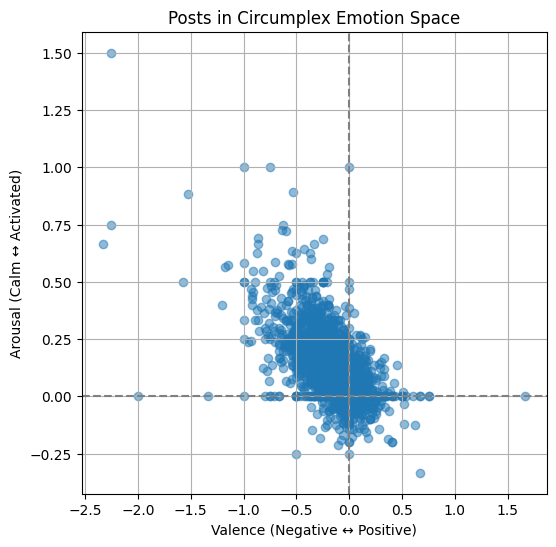

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(df['valence'], df['arousal'], alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Valence (Negative ↔ Positive)')
plt.ylabel('Arousal (Calm ↔ Activated)')
plt.title('Posts in Circumplex Emotion Space')
plt.grid(True)
plt.show()


This scatterplot displays the posts positioned in a two dimentional Circumplex Model.

<Axes: title={'center': 'Emotional Shift Over Time'}, xlabel='created_utc'>

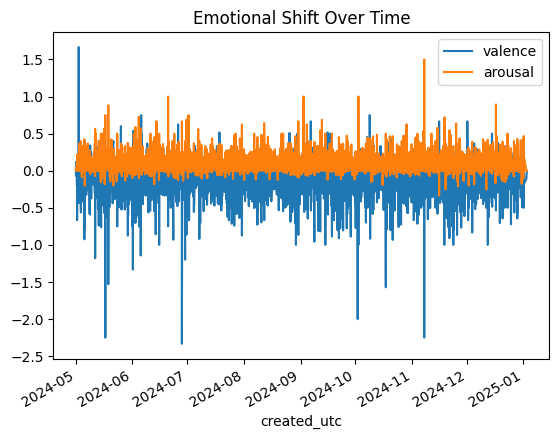

In [22]:
df['created_utc'] = pd.to_datetime(df['created_utc'])
df_sorted = df.sort_values('created_utc')
df_sorted[['created_utc', 'valence', 'arousal']].plot(x='created_utc', title='Emotional Shift Over Time')


This graph shows the emotional changes of users over time.

#### 2.3.1 Visualize Emotion Plots per User

In [23]:
user_counts = df['author'].value_counts()
active_users = user_counts[user_counts >=5].index
df_active = df[df['author'].isin(active_users)].copy()

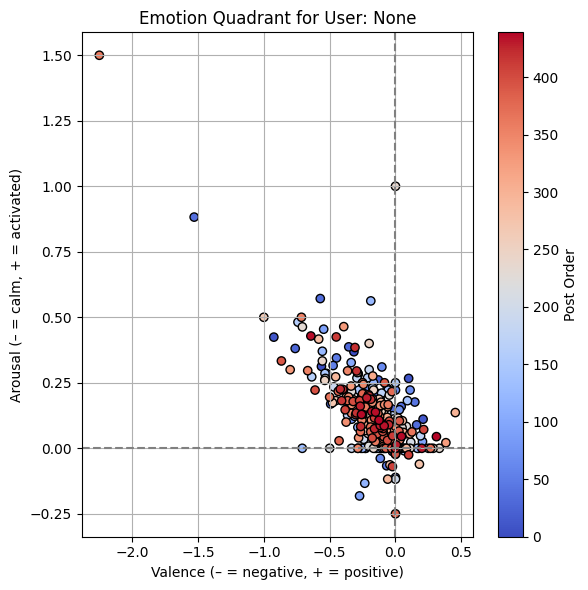

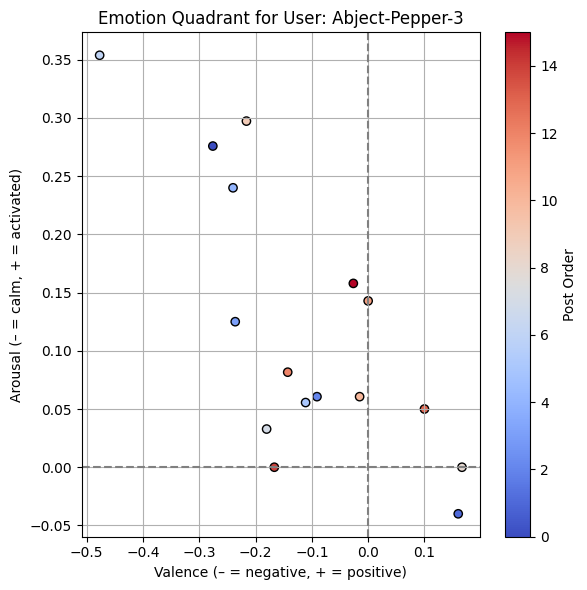

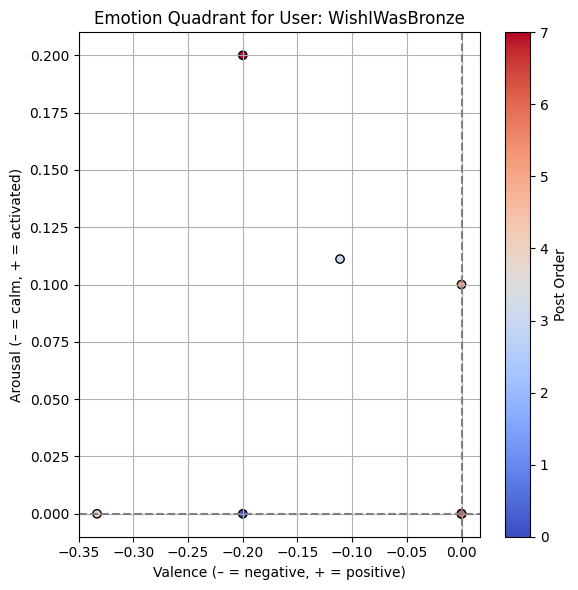

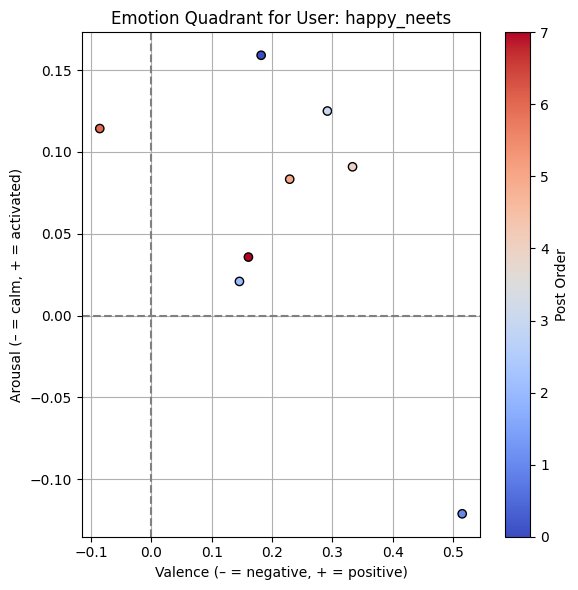

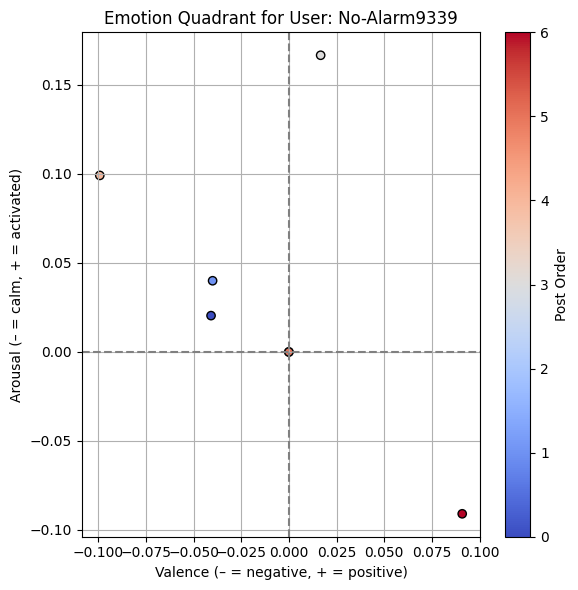

In [24]:
for user in active_users[:5]:
    user_df = df_active[df_active['author'] == user].sort_values('created_utc')
    
    plt.figure(figsize=(6, 6))
    plt.scatter(
        user_df['valence'], user_df['arousal'],
        c=range(len(user_df)), cmap='coolwarm', edgecolors='black'
    )
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f'Emotion Quadrant for User: {user}')
    plt.xlabel('Valence (– = negative, + = positive)')
    plt.ylabel('Arousal (– = calm, + = activated)')
    plt.grid(True)
    plt.colorbar(label='Post Order')
    plt.tight_layout()
    plt.show()

We filtered the user who posted over 5 posts and see each of them the changes of Emotion Quadrant.

# 3. LLM

### 3.1 Tokenization for LLM(BERT)

In [25]:
# ! pip install transformers
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
model = AutoModel.from_pretrained("mental/mental-roberta-base")

df = df[df['clean_body'].str.strip() != ""].reset_index(drop=True)

encoded_inputs = tokenizer(
    df['clean_body'].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Batch Extraction of [CLS] vectors
In BERT-based models, the [CLS] token is a special token added at the beginning of every input sequence. The model is trained so that the final vector at the [CLS] position captures a summary of the entire input post.

In [26]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create a DataLoader for the encoded inputs
batch_size = 32
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']
dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=batch_size)

# Extract CLS embeddings
embeddings = []

model.eval()
with torch.no_grad():
    for batch in loader:
        ids, mask = batch[0].to(device), batch[1].to(device)
        outputs = model(input_ids=ids, attention_mask=mask)
        cls_batch = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        embeddings.append(cls_batch.cpu())  # move to CPU for concat

# Concatenate all batches
cls_embeddings = torch.cat(embeddings, dim=0)

In [27]:
cls_array = cls_embeddings.numpy()
cls_df = pd.DataFrame(cls_array, columns=[f'cls_{i}' for i in range(cls_array.shape[1])])

## 3.3 Combine CLS + Valence/Arousal + Empath Features

In [28]:
# Flatten embeddings to 2D array
liwc_df = pd.json_normalize(df['liwc_empath'])

# Combine with original DataFrame
df_combined = pd.concat([df.reset_index(drop=True), liwc_df.reset_index(drop=True), cls_df.reset_index(drop=True)], axis=1)

print("Empath features shape:", liwc_df.shape)
print("Combined DataFrame shape:", df_combined.shape)

Empath features shape: (3769, 194)
Combined DataFrame shape: (3769, 977)


In [29]:
cls_array = cls_embeddings.numpy()

In [30]:
cls_df = pd.DataFrame(cls_array, columns=[f'cls_{i}' for i in range(cls_array.shape[1])])
df = pd.concat([df.reset_index(drop=True), cls_df.reset_index(drop=True)], axis=1)

In [31]:
# Final feature columns: CLS + valence/arousal + Empath
cls_cols = [col for col in df_combined.columns if col.startswith('cls_')]
empath_cols = liwc_df.columns.tolist()  # already flattened
final_features = cls_cols + ['valence', 'arousal'] + empath_cols

X = df_combined[final_features]
print("Final feature matrix shape:", X.shape)

Final feature matrix shape: (3769, 965)
